In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet

import warnings                               
warnings.filterwarnings('ignore')

/opt/homebrew/anaconda3/envs/linear_regession/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/train.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values(by=['Datetime'],ascending=True)
df['Date'] = df['Datetime'].dt.date

daily_avg_power = df.groupby('Date')['ActivePower'].mean()

df_train = pd.DataFrame(daily_avg_power)
df_train

,ActivePower
Date,
2018-01-01,366.223561
2018-01-02,462.550740
2018-01-03,454.417752
2018-01-04,369.952190
2018-01-05,319.446595
...,...
2020-03-11,466.289248
2020-03-12,570.315539
2020-03-13,619.637333


In [3]:
train, test = df_train[:-15], df_train[-15:]

In [4]:
test

,ActivePower
Date,
2020-03-01,443.058496
2020-03-02,390.027361
2020-03-03,341.133560
2020-03-04,122.348957
2020-03-05,676.893151
2020-03-06,345.379836
2020-03-07,516.674962
2020-03-08,629.447133
2020-03-09,673.519002


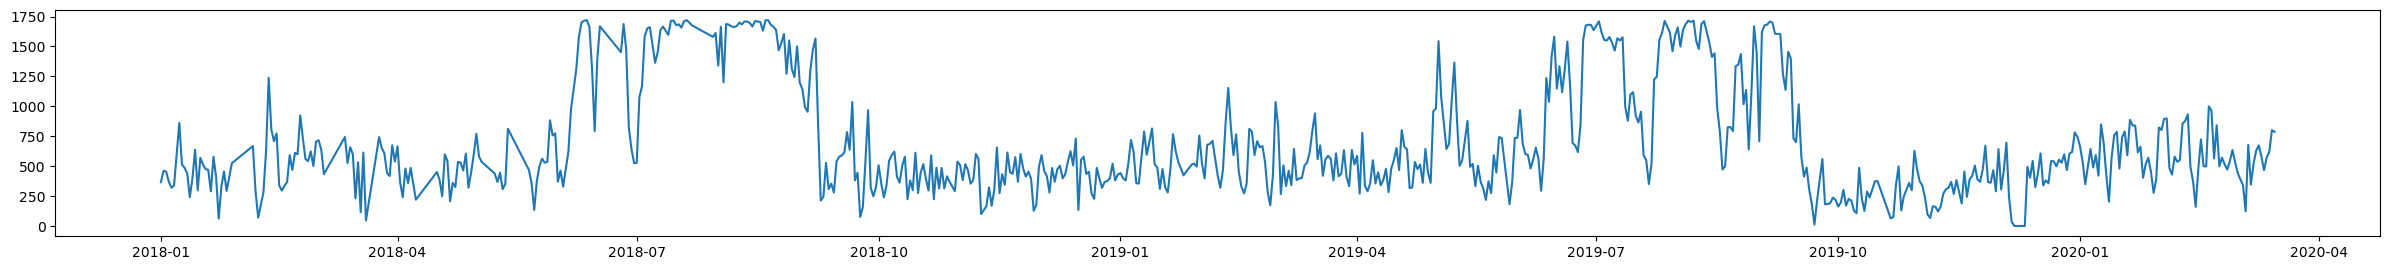

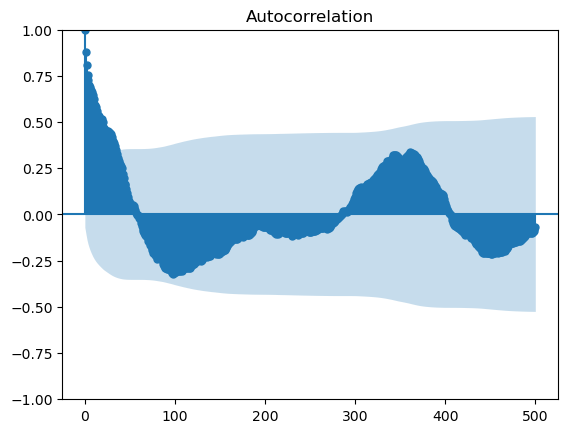

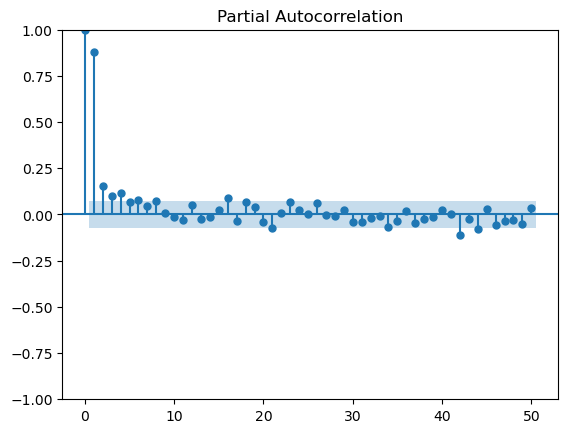

In [5]:
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)

plt.plot(df_train)
plt.show()

plot_acf(df_train,lags=500)
plot_pacf(df_train,lags=50)
plt.show()

In [6]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [7]:
adf_test(df_train)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.237316
p-value                          0.017924
#Lags Used                       7.000000
Number of Observations Used    726.000000
Critical Value (1%)             -3.439389
Critical Value (5%)             -2.865529
Critical Value (10%)            -2.568894
dtype: float64


Seems stationary to me

In [8]:
#check trend with MA smoothing
#def a moving average plot
def plotMovingAverage(series, window, plot_actual=False, scale=1.96):

    rolling_mean = series.rolling(window=window,center=True).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    if plot_actual:
        plt.plot(series[window:], label="Actual values", color='#878a88', alpha=0.5)
        
    plt.legend(loc="upper left") 
    plt.grid(True)

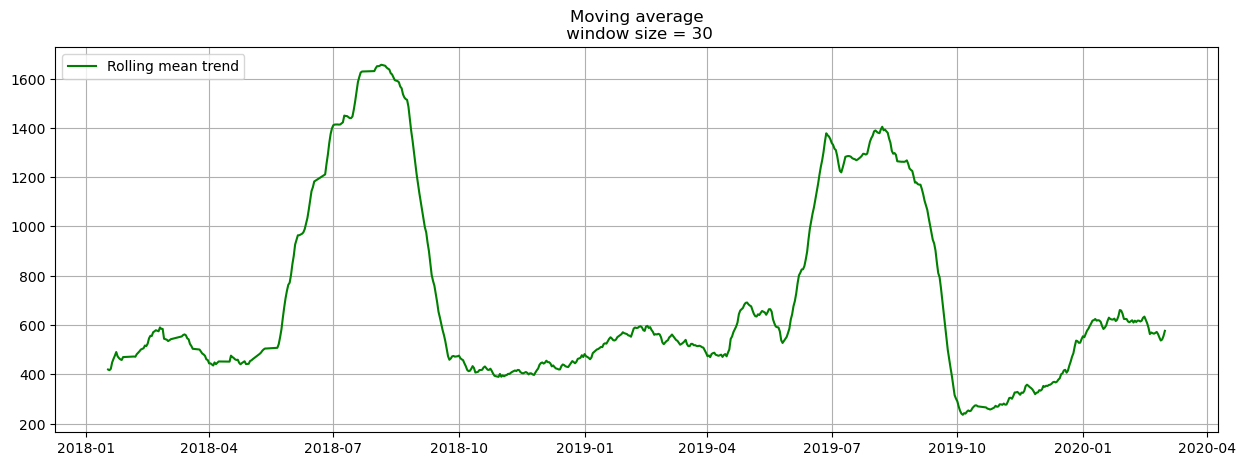

In [9]:
plotMovingAverage(df_train['ActivePower'], 30) # monthly

In [10]:
# define the function to difference the data ONCE
def diff(data, interval):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

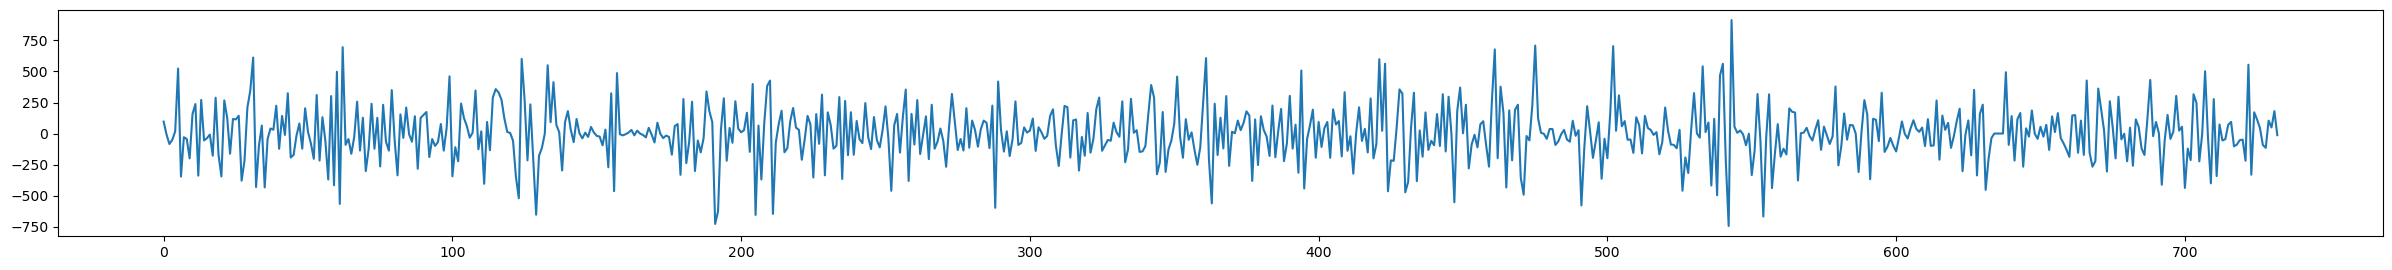

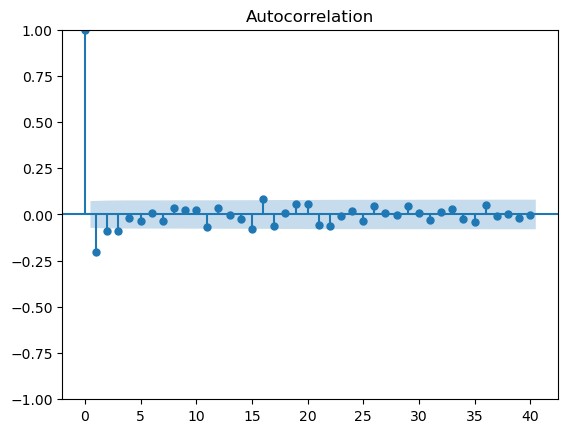

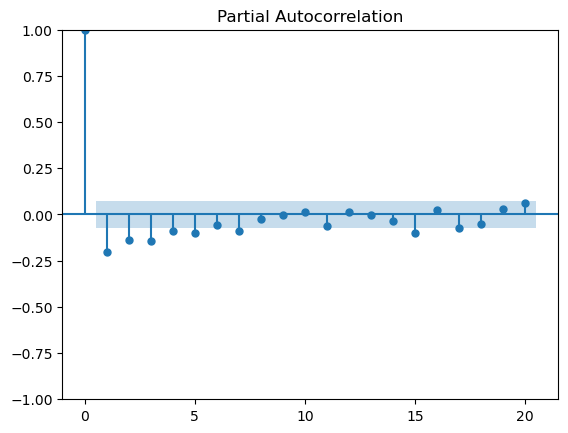

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.424690e+01
p-value                        1.504064e-26
#Lags Used                     6.000000e+00
Number of Observations Used    7.260000e+02
Critical Value (1%)           -3.439389e+00
Critical Value (5%)           -2.865529e+00
Critical Value (10%)          -2.568894e+00
dtype: float64


In [11]:
D1=diff(df_train['ActivePower'],1)
#visualize the differenced data
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)

plt.plot(D1)
plt.show()

plot_acf(D1,lags=40)
plt.show()

plot_pacf(D1,lags=20)
plt.show()

adf_test(D1)

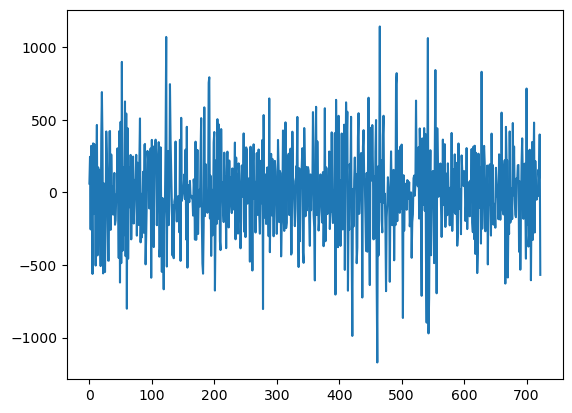

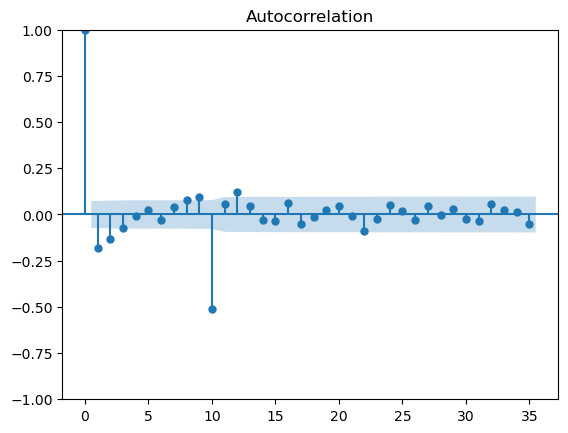

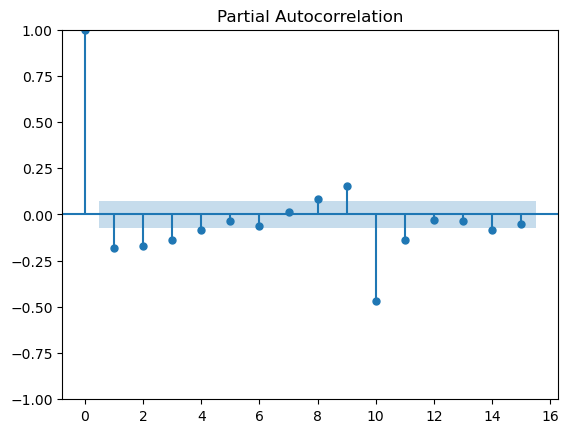

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.002367e+01
p-value                        1.653547e-17
#Lags Used                     2.000000e+01
Number of Observations Used    7.020000e+02
Critical Value (1%)           -3.439700e+00
Critical Value (5%)           -2.865666e+00
Critical Value (10%)          -2.568967e+00
dtype: float64


In [12]:
#check the de-seasoned data
deseason_df = diff(D1, 10)
plt.plot(deseason_df)
plot_acf(deseason_df ,lags=35) 
plot_pacf(deseason_df ,lags=15) 
plt.show()
adf_test(deseason_df)

#### SARIMA

In [85]:
def evaluate_models_cv(dataset, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    K=5
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                trend_order = (p,d,q)
                                seasonal_order = (P,D,Q,m)
                                cfg = [(p,d,q), (P,D,Q,m)]
                                validation_size=15
                                train_size=len(dataset)-validation_size*K
                                rmse=0
                                for k in range(0,5):
                                    train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                    model = ARIMA(train, order=trend_order, seasonal_order=seasonal_order) #each step: rolling one step forward to update the train se
                                    model_fit = model.fit()
                                    predictions=model_fit.forecast(validation_size)
                                    rmse = rmse+np.sqrt(skmetrics.mean_squared_error(test, predictions))
                                rmse_avg=rmse/5
                                result.append((cfg, rmse_avg))
                                if rmse_avg < best_rmse:
                                    best_rmse, best_cfg = rmse_avg, cfg
                                print('ARIMA%s RMSE=%.3f' % (cfg,rmse_avg))
                            except:
                                pass
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_rmse))


In [86]:
p=[0,1,2]
d=[1,2]
q=[0,1,2]
P=[0,1,2]
D=[1]
Q=[0,1,2]
m=10
evaluate_models_cv(train['ActivePower'], p,d,q,P,D,Q,m)

ARIMA[(0, 1, 0), (0, 1, 0, 10)] RMSE=438.488
ARIMA[(0, 1, 0), (0, 1, 1, 10)] RMSE=297.655
ARIMA[(0, 1, 0), (1, 1, 0, 10)] RMSE=424.062
ARIMA[(0, 1, 0), (1, 1, 1, 10)] RMSE=298.239
ARIMA[(0, 1, 0), (1, 1, 2, 10)] RMSE=297.686
ARIMA[(0, 1, 0), (2, 1, 0, 10)] RMSE=383.269
ARIMA[(0, 1, 0), (2, 1, 1, 10)] RMSE=304.749
ARIMA[(0, 1, 0), (2, 1, 2, 10)] RMSE=305.175
ARIMA[(0, 1, 1), (0, 1, 0, 10)] RMSE=438.284
ARIMA[(0, 1, 1), (0, 1, 1, 10)] RMSE=282.910
ARIMA[(0, 1, 1), (0, 1, 2, 10)] RMSE=283.428
ARIMA[(0, 1, 1), (1, 1, 0, 10)] RMSE=435.331
ARIMA[(0, 1, 1), (1, 1, 1, 10)] RMSE=283.495
ARIMA[(0, 1, 1), (1, 1, 2, 10)] RMSE=289.147
ARIMA[(0, 1, 1), (2, 1, 0, 10)] RMSE=387.036
ARIMA[(0, 1, 1), (2, 1, 1, 10)] RMSE=291.778
ARIMA[(0, 1, 1), (2, 1, 2, 10)] RMSE=289.834
ARIMA[(0, 1, 2), (0, 1, 0, 10)] RMSE=400.091
ARIMA[(0, 1, 2), (0, 1, 1, 10)] RMSE=246.054
ARIMA[(0, 1, 2), (0, 1, 2, 10)] RMSE=246.796
ARIMA[(0, 1, 2), (1, 1, 0, 10)] RMSE=402.782
ARIMA[(0, 1, 2), (1, 1, 1, 10)] RMSE=246.895
ARIMA[(0, 

In [87]:
model = ARIMA(train['ActivePower'],order=(1,1,1),seasonal_order=(1,1,1,10)).fit()
pred = model.forecast(15)
pred = pd.DataFrame(pred)

In [88]:
np.sqrt(skmetrics.mean_squared_error(test, pred))

184.8513108887397

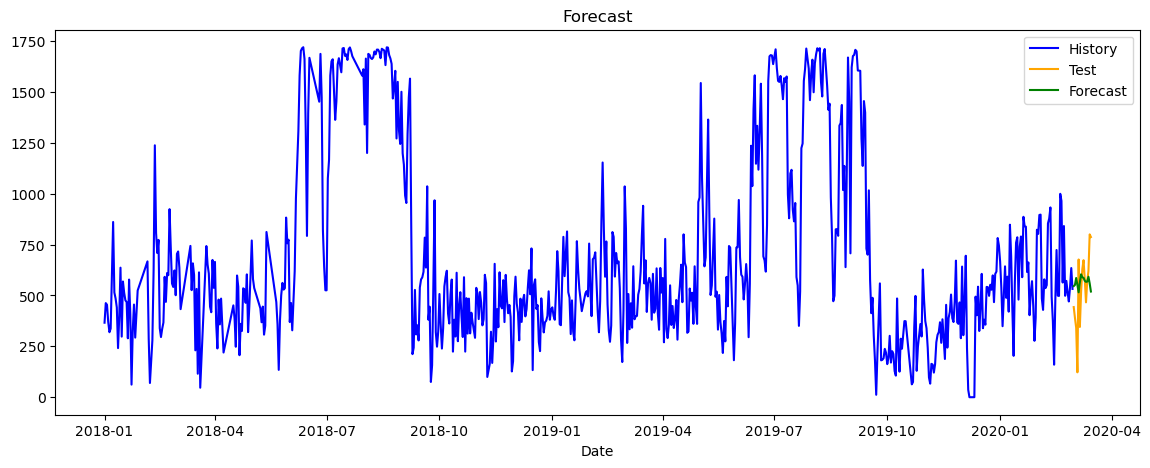

In [116]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
train['Date'] = train.index.values
test['Date'] = test.index.values
pred['Date'] = test.index.values
train.plot(kind='line',x='Date' , y='ActivePower', color='blue', label='History', ax=ax)
test.plot(kind='line',x='Date' , y='ActivePower', color='orange', label='Test', ax=ax)
pred.plot(kind='line', x='Date', y='predicted_mean', color='green', label='Forecast', ax=ax)
plt.title('Forecast')
plt.show()

#### ETS

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_1 = ExponentialSmoothing(train['ActivePower'], trend="add", seasonal="add", seasonal_periods=12, damped_trend=False).fit()
model_2 = ExponentialSmoothing(train['ActivePower'], trend="add", seasonal="add", seasonal_periods=12, damped_trend=True).fit()

In [14]:
pred_1 = pd.DataFrame(model_1.forecast(len(test)))
pred_2 = pd.DataFrame(model_2.forecast(len(test)))

In [15]:
pred_1

,0
719,575.442050
720,590.158052
721,569.058200
722,579.601066
723,610.452862
724,568.253656
725,563.833758
726,558.590295
727,601.112890
728,634.267047


In [16]:
np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], pred_1))

176.4568129673209

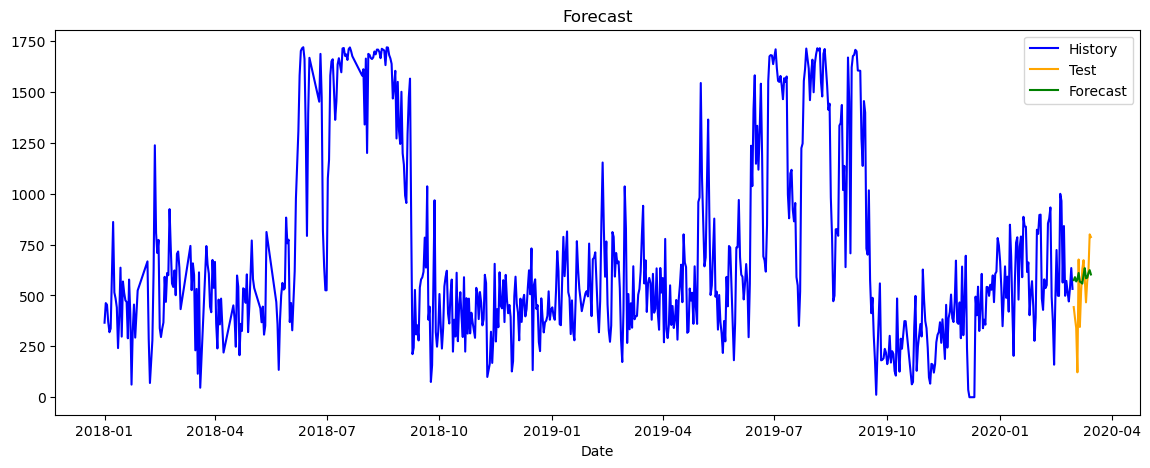

In [138]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
train['Date'] = train.index.values
test['Date'] = test.index.values
pred_1['Date'] = test.index.values
train.plot(kind='line',x='Date' , y='ActivePower', color='blue', label='History', ax=ax)
test.plot(kind='line',x='Date' , y='ActivePower', color='orange', label='Test', ax=ax)
pred_1.plot(kind='line', x='Date', y=0, color='green', label='Forecast', ax=ax)
plt.title('Forecast')
plt.show()

In [139]:
np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], pred_2))

179.25662983743712

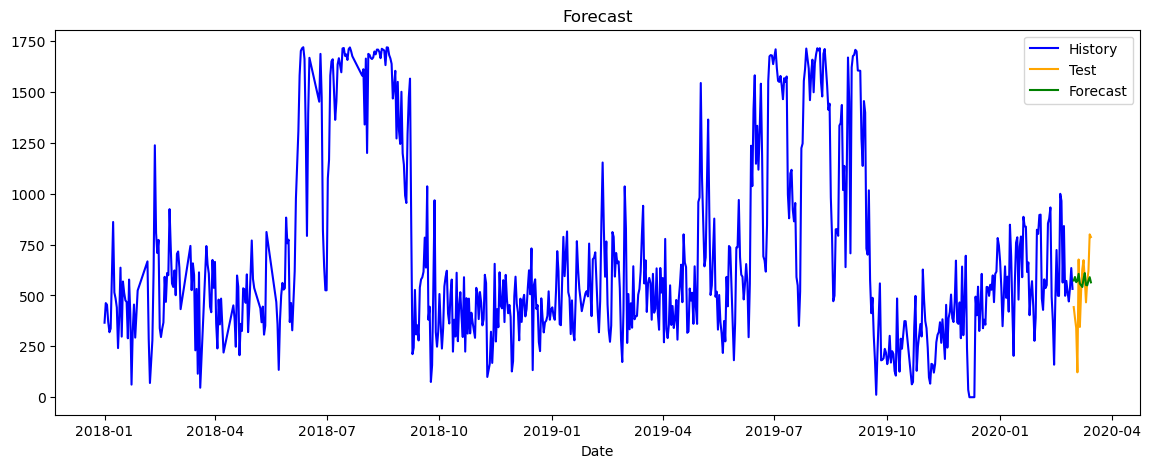

In [140]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
train['Date'] = train.index.values
test['Date'] = test.index.values
pred_2['Date'] = test.index.values
train.plot(kind='line',x='Date' , y='ActivePower', color='blue', label='History', ax=ax)
test.plot(kind='line',x='Date' , y='ActivePower', color='orange', label='Test', ax=ax)
pred_2.plot(kind='line', x='Date', y=0, color='green', label='Forecast', ax=ax)
plt.title('Forecast')
plt.show()

#### Prophet

In [142]:
df_train['ds'] = df_train.index.values
df_train['y'] = df_train['ActivePower']
train, test = df_train[:-15], df_train[-15:]

In [143]:
#Prophet project
m = Prophet()

#Fit with default settings
m.fit(train)
#Fataframe with forecasting steps
future = m.make_future_dataframe(periods=len(test))
#Forecast
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:51:35 - cmdstanpy - INFO - Chain [1] start processing
18:51:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
729,2020-03-11,534.591417,219.562260,882.999173
730,2020-03-12,558.251296,254.356441,872.760132
731,2020-03-13,510.032975,195.941624,835.766332
732,2020-03-14,516.856625,187.873211,853.930431
733,2020-03-15,505.334716,175.849452,797.074377


In [144]:
np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], forecast['yhat'][-15:]))

179.7794079527869

18:51:37 - cmdstanpy - INFO - Chain [1] start processing
18:51:37 - cmdstanpy - INFO - Chain [1] done processing


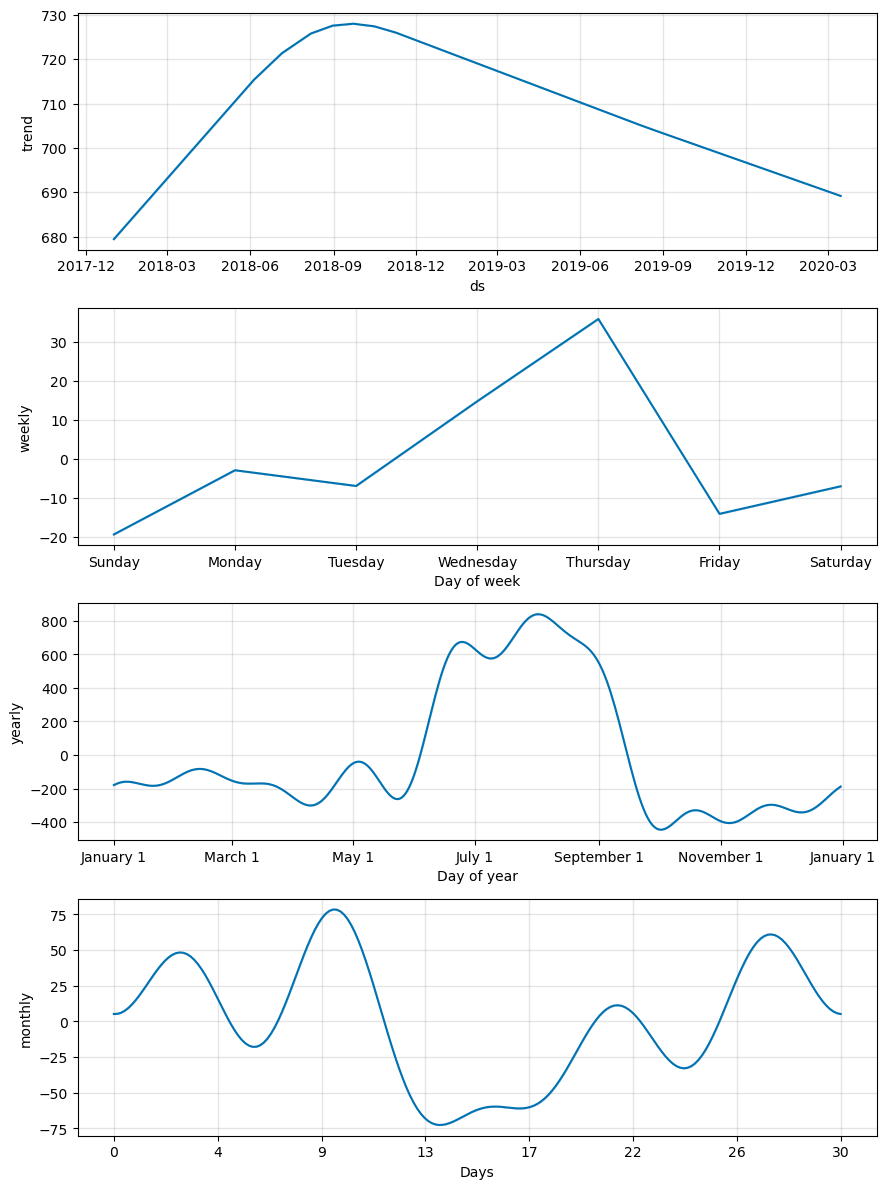

In [145]:
m = Prophet()
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(train).predict(future)
fig = m.plot_components(forecast)

In [146]:
np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], forecast['yhat'][-15:]))

177.5487289539304

### Selecting model - ETS

In [19]:
model = ExponentialSmoothing(df_train['ActivePower'], trend="add", seasonal="add", seasonal_periods=12, damped_trend=False).fit()
pred = pd.DataFrame(model.forecast(len(test)))
pred.values

array([[763.99255432],
       [835.28642036],
       [757.28351055],
       [768.99362665],
       [765.4949999 ],
       [802.61829854],
       [829.42396395],
       [784.35232326],
       [797.11512043],
       [815.32080819],
       [839.0423744 ],
       [808.80861252],
       [806.63888427],
       [877.93275032],
       [799.9298405 ]])

In [20]:
start_date = '2020-03-16'
end_date = '2020-03-30'

# Create a list of dates
date_list = pd.date_range(start=start_date, end=end_date, freq='D').strftime('%Y-%m-%d').tolist()

df_forecast = pd.DataFrame(pred.values, date_list, columns=['Forecasting'])
df_forecast['Date'] = df_forecast.index.values


In [21]:
df_forecast

,Forecasting,Date
2020-03-16,763.992554,2020-03-16
2020-03-17,835.286420,2020-03-17
2020-03-18,757.283511,2020-03-18
2020-03-19,768.993627,2020-03-19
2020-03-20,765.495000,2020-03-20
2020-03-21,802.618299,2020-03-21
2020-03-22,829.423964,2020-03-22
2020-03-23,784.352323,2020-03-23
2020-03-24,797.115120,2020-03-24
2020-03-25,815.320808,2020-03-25


In [22]:
df_forecast = df_forecast[['Date','Forecasting']]
df_forecast.to_csv('test_forecast.csv', index=False)